# Recurrent network for fake news classification using tokens/embedding for single words instead of embedding for whole document

In [123]:
#!pip install torchvision --quiet

import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
from itertools import islice

# nlp stuff
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize 
   
# PyTorch libraries
import torch
import nlp_nets as nlp
from torch import nn
import torch.optim as optim
from os.path import join as opj
from torch.utils.data import DataLoader, TensorDataset, random_split
from tqdm.auto import tqdm

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [8]:
data_folder = r'/Users/AdamHarris/Documents/neuromatch_nlp/Neuromatch_NLP/dataset'

test_df = pd.read_csv(f'{data_folder}/test_df.csv')
val_df = pd.read_csv(f'{data_folder}/validation_df.csv')
train_df = pd.read_csv(f'{data_folder}/train_df.csv')

test_txt = test_df['text']
test_label = test_df['label']


train_txt = train_df['text']
train_label = train_df['label']


val_txt = val_df['text']
val_label = val_df['label']


In [31]:
test_label

0       0
1       1
2       1
3       0
4       1
       ..
8848    0
8849    0
8850    0
8851    1
8852    1
Name: label, Length: 8853, dtype: int64

In [9]:
test_df['text'][0]

'jakarta indonesia military said friday prepared take tough measures rebels threatened destroy mining operations freeport mcmoran inc eastern province papua independence struggle police say armed separatist group linked free papua movement opm preventing people five villages leaving area near giant grasberg copper mine operated unit arizona based company state emergency declared least additional security forces deployed area string shootings since aug killed one police officer wounded six group west papua national liberation army tpn opm friday denied occupying villages near mine hendrik wanmang representative tpn opm said none fighters stationed villages cannot mingle community wanmang said telephone interview would endanger wanmang also denied police allegations group carried rape torture civilians saying villagers continuing carry activities usual warned freeport employees security personnel remained area risk war national police indonesian military freeport said tpn opm continue fi

In [10]:
def emo_str2arr(list_of_strings):  
    all_emo = []
    for float_list_str  in list_of_strings:
        float_list_str = float_list_str.strip('[]')
        float_str_elements = float_list_str.split()
        all_emo.append(np.array([float(element) for element in float_str_elements]))
    all_emo = np.vstack(all_emo)
    return all_emo


In [11]:
xxx = emo_str2arr(test_df['emotions'])

In [12]:
xxx


array([[0.00202758, 0.00892133, 0.01257097, ..., 0.00729927, 0.01459854,
        0.00243309],
       [0.00299302, 0.00498836, 0.00931161, ..., 0.00332557, 0.00332557,
        0.0023279 ],
       [0.00445931, 0.01114827, 0.01003344, ..., 0.00222965, 0.00445931,
        0.00668896],
       ...,
       [0.00284091, 0.00568182, 0.01136364, ..., 0.00568182, 0.00852273,
        0.00568182],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00182371, 0.01033435, 0.00911854, ..., 0.00303951, 0.00547112,
        0.00607903]])

### Tokenisation and word embedding

In [13]:
def tokenize(text):
    return text.lower().split()

In [14]:
tokenized_train = [tokenize(text) for text in train_txt]
tokenized_val = [tokenize(text) for text in val_txt]
tokenized_test = [tokenize(text) for text in test_txt]

In [15]:
"""
apparently, while it is technically possible for RNNs to handle variable input length input,
in practice this makes things tricky. 
here's the preprocessing steps i've seen other people use:
1 - tokenise (i.e. split article into individual words)
2 - use this to build a dictionary of individual words
3 - rank order by word frequency
4 - consider only the most common n words (e.g. a dictionary of 40,000)
5 - assign each word a number based on it's position in the ranked frequency
6 - choose a 'sentence length' hyperparameter. ours may be in the hundreds because the articles are longer than other nlp data ive seen (tweets)
7 - use the word number ids for each article in the right order to get a vector of length==sentence_length (e.g. [34,1,2,45,3, ...], or [0,0,0,0,34,56, ...])
This fixed sentence length makes things like batch processing play much nicer
"""

"\napparently, while it is technically possible for RNNs to handle variable input length input,\nin practice this makes things tricky. \nhere's the preprocessing steps i've seen other people use:\n1 - tokenise (i.e. split article into individual words)\n2 - use this to build a dictionary of individual words\n3 - rank order by word frequency\n4 - consider only the most common n words (e.g. a dictionary of 40,000)\n5 - assign each word a number based on it's position in the ranked frequency\n6 - choose a 'sentence length' hyperparameter. ours may be in the hundreds because the articles are longer than other nlp data ive seen (tweets)\n7 - use the word number ids for each article in the right order to get a vector of length==sentence_length (e.g. [34,1,2,45,3, ...], or [0,0,0,0,34,56, ...])\nThis fixed sentence length makes things like batch processing play much nicer\n"

In [16]:
def make_word_freq_dic(tokens_article_list):
    """
    Takes list of tokenised articles and returns an ordered dictionary
    of the tokens and their corresponding counts

    Args:
      tokens_article_list: list
        list of lists of tokens

    Returns:
      dictionary: OrderedDict
    """     
    dictionary = {}
    for article in tqdm(tokens_article_list):
        for token in article:
            if token not in dictionary.keys():
                dictionary[token]=1
            else:
                dictionary[token]+=1
    sorted_dictionary = sorted(dictionary.items(), key=lambda item: item[1], reverse=True)
    ordered_dictionary = OrderedDict(sorted_dictionary)
    return ordered_dictionary

In [17]:
word_freq_train = make_word_freq_dic(tokenized_train)
dict_size = 30000
word_freq_train_trunc = OrderedDict(islice(word_freq_train.items(), dict_size))
print(len(word_freq_train_trunc))

100%|██████████| 26559/26559 [00:02<00:00, 12743.69it/s]


30000


In [18]:
word_to_position = {word: i + 1 for i, word in enumerate(word_freq_train_trunc)}

In [19]:
word_freq_train_trunc

OrderedDict([('trump', 80705),
             ('said', 79563),
             ('president', 33709),
             ('would', 32973),
             ('u', 32663),
             ('people', 24963),
             ('one', 22672),
             ('state', 20745),
             ('also', 18715),
             ('new', 18696),
             ('clinton', 16944),
             ('donald', 16887),
             ('obama', 16820),
             ('house', 16530),
             ('government', 16477),
             ('states', 16090),
             ('republican', 15134),
             ('year', 15119),
             ('could', 14309),
             ('united', 14144),
             ('white', 13519),
             ('like', 13497),
             ('two', 13192),
             ('campaign', 12848),
             ('election', 12793),
             ('told', 12716),
             ('time', 12682),
             ('last', 12505),
             ('news', 12285),
             ('party', 12141),
             ('first', 11705),
             ('washington', 111

In [180]:

import json

file_path = f'{data_folder}/word_to_position.json'

# Open the file in write mode and use json.dump() to serialize the dictionary to JSON
with open(file_path, 'w') as file:
    json.dump(word_to_position, file, indent=4)  
    
file_path = f'{data_folder}/word_freq_train.json'

# Open the file in write mode and use json.dump() to serialize the dictionary to JSON
with open(file_path, 'w') as file:
    json.dump(word_freq_train, file, indent=4)  
    

In [20]:
word_to_position

{'trump': 1,
 'said': 2,
 'president': 3,
 'would': 4,
 'u': 5,
 'people': 6,
 'one': 7,
 'state': 8,
 'also': 9,
 'new': 10,
 'clinton': 11,
 'donald': 12,
 'obama': 13,
 'house': 14,
 'government': 15,
 'states': 16,
 'republican': 17,
 'year': 18,
 'could': 19,
 'united': 20,
 'white': 21,
 'like': 22,
 'two': 23,
 'campaign': 24,
 'election': 25,
 'told': 26,
 'time': 27,
 'last': 28,
 'news': 29,
 'party': 30,
 'first': 31,
 'washington': 32,
 'country': 33,
 'even': 34,
 'former': 35,
 'us': 36,
 'hillary': 37,
 'many': 38,
 'years': 39,
 'american': 40,
 'media': 41,
 'security': 42,
 'law': 43,
 'made': 44,
 'may': 45,
 'national': 46,
 'say': 47,
 'political': 48,
 'get': 49,
 'police': 50,
 'since': 51,
 'right': 52,
 'court': 53,
 'percent': 54,
 'make': 55,
 'going': 56,
 'back': 57,
 'twitter': 58,
 'russia': 59,
 'according': 60,
 'republicans': 61,
 'administration': 62,
 'america': 63,
 'presidential': 64,
 'don': 65,
 'bill': 66,
 'week': 67,
 'via': 68,
 'called': 69,

In [21]:
def keep_only_dict_tokens(list_of_articles, dictionary):
    cleaned_all = []
    for article in tqdm(list_of_articles):
        cleaned_article = [i for i in article if i in dictionary.keys()]
        cleaned_all.append(cleaned_article)
    return cleaned_all

filtered_train = keep_only_dict_tokens(tokenized_train, word_freq_train_trunc)
filtered_val = keep_only_dict_tokens(tokenized_val, word_freq_train_trunc)
filtered_test = keep_only_dict_tokens(tokenized_test, word_freq_train_trunc)

100%|██████████| 8853/8853 [00:00<00:00, 14541.84it/s]


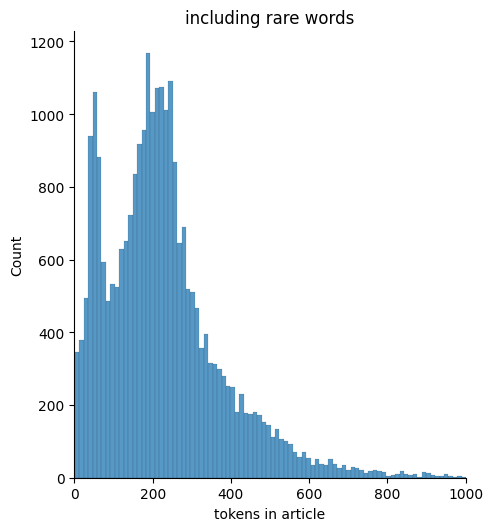

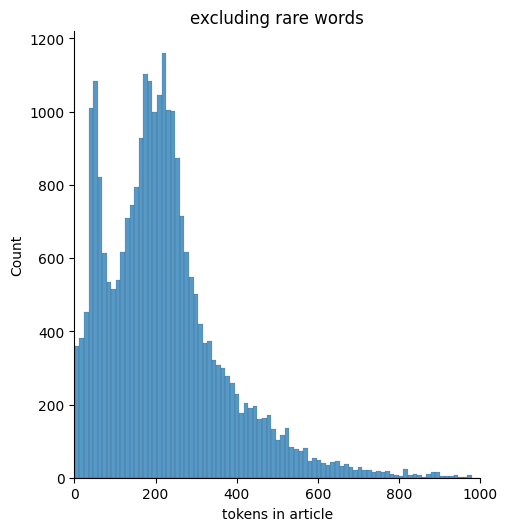

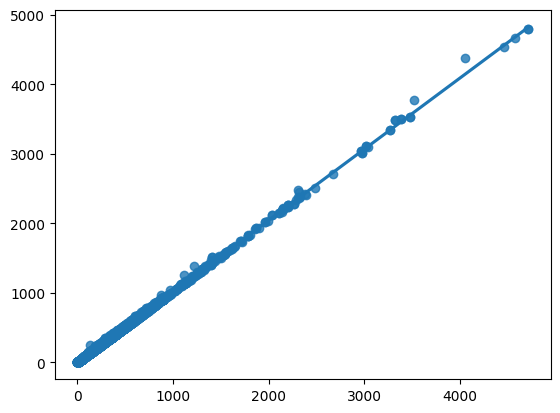

[ 1  3 11 ...  1  4  0]
119873 total words removed


In [22]:
article_length_tokens = []
for i in tokenized_train:
    article_length_tokens.append(len(i))
sns.displot(article_length_tokens)
plt.xlim(0, 1000)
plt.xlabel('tokens in article')
plt.title('including rare words')
plt.show()


article_length_tokens_filt = []
for i in filtered_train:
    article_length_tokens_filt.append(len(i))
sns.displot(article_length_tokens_filt)
plt.xlim(0, 1000)
plt.xlabel('tokens in article')
plt.title('excluding rare words')
plt.show()


sns.regplot(x=article_length_tokens_filt, y=article_length_tokens)
plt.show()
diffs = np.array(article_length_tokens)-np.array(article_length_tokens_filt)
print(diffs)
print(f'{diffs.sum()} total words removed')

In [25]:
MAX_ARTICLE_LENGTH = 400

def make_article_array(filtered_arr, MAX_ARTICLE_LENGTH=400):
    all_article_vects =[]
    for artile in filtered_arr:
        ints_replace_words=[word_to_position[i] for i in artile]
        article_length = len(ints_replace_words)
        if article_length>MAX_ARTICLE_LENGTH:
            article_vect = np.array(ints_replace_words[:MAX_ARTICLE_LENGTH])
        elif article_length == MAX_ARTICLE_LENGTH:
            article_vect = np.array(ints_replace_words)
        else:
            article_vect=np.zeros((MAX_ARTICLE_LENGTH,))
            len_diff = MAX_ARTICLE_LENGTH-article_length
            article_vect[len_diff:]=ints_replace_words
        all_article_vects.append(article_vect)

    filtered_arr = np.vstack(all_article_vects)
    return filtered_arr
    
train_array=make_article_array(filtered_train)

val_array=make_article_array(filtered_val)

test_array=make_article_array(filtered_test)




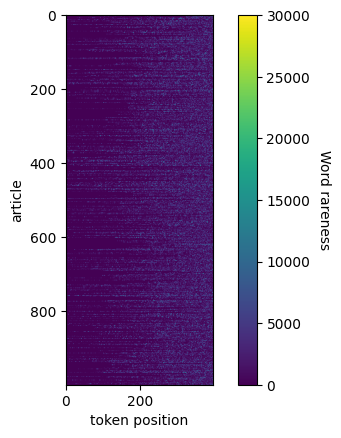

In [26]:
fig, ax = plt.subplots()
cax = ax.imshow(train_array[:1000, :])
plt.ylabel('article')
plt.xlabel('token position')
cbar = plt.colorbar(cax)
cbar.set_label('Word rareness', rotation=270, labelpad=15)

In [89]:
xxx=  np.zeros((6,))
xxx[:2]=[2,2]


In [66]:
np.array(test_label)

array([0, 1, 1, ..., 0, 1, 1])

In [30]:
# train_labels=np.load(f'{data_folder}/train_labels.npy')
# val_labels=np.load(f'{data_folder}/validation_labels.npy')
# test_labels=np.load(f'{data_folder}/test_labels.npy')

In [178]:
np.save(f'{data_folder}/rnn_train_array.npy',train_array)
np.save(f'{data_folder}/rnn_test_array.npy',test_array)
np.save(f'{data_folder}/rnn_val_array.npy',val_array)

In [91]:
train_data = TensorDataset(torch.tensor(train_array.astype(int),dtype=torch.long), 
                           torch.tensor(np.array(train_label),dtype=torch.long))
val_data = TensorDataset(torch.tensor(val_array.astype(int),dtype=torch.long), 
                         torch.tensor(np.array(val_label),dtype=torch.long))
test_data = TensorDataset(torch.tensor(test_array.astype(int),dtype=torch.long),
                           torch.tensor(np.array(test_label),dtype=torch.long))

BATCH_SIZE = 100

# dataloaders
# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE,drop_last = True)
val_loader = DataLoader(val_data, shuffle=True, batch_size=BATCH_SIZE,drop_last = True)

In [92]:
train_data[0][0].dtype

torch.int64

In [141]:
import importlib
importlib.reload(nlp)

GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


<module 'nlp_nets' from '/Users/AdamHarris/Documents/neuromatch_nlp/Neuromatch_NLP/Code/nlp_nets.py'>

# Now let's define the network

In [142]:
class FakeNewsRNN(nn.Module):
  """
  Initialize LSTM Network
  """

  def __init__(self, num_layers, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_p=0.1):
    """
    Initialize LSTM Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer, list of integers
      output_dim: int
        Number of output features

    Returns:
      Nothing
    """
 
    super(FakeNewsRNN, self).__init__()
    self.output_dim=output_dim
    self.hidden_dim=hidden_dim
    self.embedding_dim=embedding_dim
    self.dropout_p=dropout_p
    self.vocab_size=vocab_size
    self.embedding = nn.Embedding(vocab_size, embedding_dim)
    self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, dropout=dropout_p, batch_first=True)
    self.fc = nn.Linear(hidden_dim, output_dim)
    self.softmax = nn.Softmax(dim=1)

   
        

  def forward(self, x):
    """
    Simulate forward pass of RNN Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance o
        Forward pass of RNN
    """ 
    embedded = self.embedding(x.long())
    lstm_out, _ = self.lstm(embedded)
    lstm_out = lstm_out[:, -1, :]  # Get the last output of the sequence

    out = self.fc(lstm_out)
    act_out = self.softmax(out)
    return act_out

In [143]:
vocab_size = dict_size + 1# Adjust this based on your dataset
embedding_dim = 30
hidden_dim = 60
output_dim = 2  # Number of classes
num_layers = 1
dropout_p=0.1

rnn = FakeNewsRNN(num_layers, vocab_size, embedding_dim, hidden_dim, output_dim, dropout_p)

/Users/AdamHarris/miniconda3/envs/par2vec/lib/python3.11/site-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [144]:
SEED = 5
nlp.set_seed(SEED)
DEVICE = nlp.set_device()
g_seed = torch.Generator()
g_seed.manual_seed(SEED)

Random seed 5 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [145]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(rnn.parameters(), lr=1e-3)
num_epochs = 100

100%|██████████| 100/100 [2:23:02<00:00, 85.82s/it]  


Accuracy on the 26500 training samples: 99.83
Accuracy on the 8800 testing samples: 98.38


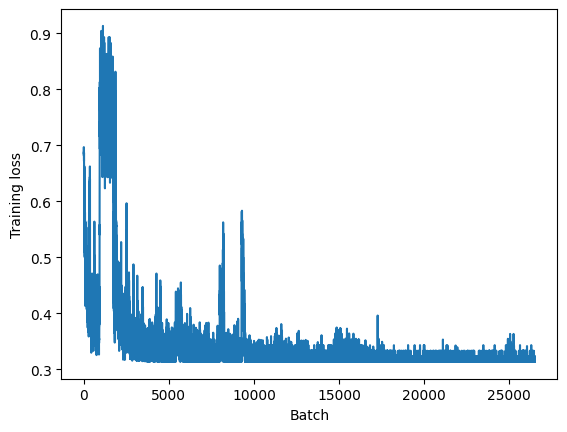

In [146]:
_, _,t_loss, v_loss = nlp.RNN_train_test_classification(rnn, criterion, optimizer, train_loader,
                                    val_loader, num_epochs=num_epochs,
                                    training_plot=True, device=DEVICE)

In [176]:
from torch.utils.tensorboard import SummaryWriter


# TensorBoard writer
dummy_input = torch.randint(1, vocab_size-1000, (100, 400))

# Initialize TensorBoard writer
writer = SummaryWriter("runs/experiment_1")
for n_iter in range(100): #add random scalars for verification
    writer.add_scalar('Loss/train', torch.randn(1).item(), n_iter)
    writer.add_scalar('Accuracy/train', torch.rand(1).item(), n_iter)
# Add the model graph to TensorBoard
writer.add_graph(rnn, dummy_input)
writer.close()

In [174]:
%tensorboard

UsageError: Line magic function `%tensorboard` not found.


In [147]:
torch.save(rnn, f'{data_folder}/rnn_model.pth')

### Checking data loaders

In [111]:
dataiter = iter(train_loader)
sample_x, sample_y = dataiter.__next__()

print('Sample input size: ', sample_x.size()) # batch_size, seq_length\
print('type'+str(sample_x.dtype))
print('type'+str(sample_y.dtype))
print('Sample input: \n', sample_x)
print('Sample input: \n', sample_y)

Sample input size:  torch.Size([100, 400])
typetorch.int64
typetorch.int64
Sample input: 
 tensor([[    0,     0,     0,  ...,    80,   197, 13994],
        [    0,     0,     0,  ...,  1789,   151,   397],
        [    0,     0,     0,  ...,   376,  2175,  2840],
        ...,
        [    0,     0,     0,  ...,  3674,  3050,   458],
        [    0,     0,     0,  ...,  4915,  1749,   968],
        [    0,     0,     0,  ...,  3718,   436,   385]])
Sample input: 
 tensor([0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
        0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0,
        0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1,
        1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 1])


In [122]:
!pip install tensorboard

  Using cached Markdown-3.6-py3-none-any.whl.metadata (7.0 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 1.6 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 1.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 2.5 MB/s eta 0:00:0000:0100:01
Using cached Markdown-3.6-py3-none-any.whl (105 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 394.2/394.2 kB 2.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 2.7 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 2.3 MB/s eta 0:00:00a 0:00:01
